In [4]:
import torch
from torch.autograd import Variable

In [14]:
#deriv[0] = state[1]
#deriv[1] = float(-(m * g * l * torch.sin(state[0:1])) - b*state[1] + u)

x = Variable(torch.FloatTensor([3.1415, 0.5, 0.0]), requires_grad=True)
y = torch.cos(x)
y.backward(torch.FloatTensor([1.0]),retain_graph=True)

print x.grad.data


-0.0001
-0.4794
-0.0000
[torch.FloatTensor of size 3]



## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [16]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]), requires_grad=True)
print x_i

### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    return x.pow(2).sum()

### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
print K

## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg
b = 10.0    # damping

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2))
    xdot[0] = x[1]
    u = -torch.dot(K,x)
    xdot[1] = -(m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot


xdot = dynamics(x_i)
print xdot

### Step 5: compute Vdot

def compute_Vdot(x):
    V = compute_V(x)
    V.backward(torch.FloatTensor([1.0]),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot
    
Vdot = compute_Vdot(x_i)
print Vdot
Vdot.backward()

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
   1.1000
-261.5925
[torch.FloatTensor of size 2]

Variable containing:
-573.3034
[torch.FloatTensor of size 1]



## Let's test for a K
 
K = [1, 2] shouldn't be stable?

In [18]:
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
-1.2404
 1.1239
[torch.FloatTensor of size 2]



## Now let's search for K, from an initialization not stable

In [19]:
K = Variable(torch.FloatTensor([-1, 2]), requires_grad=True)

for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
 0.4172
-0.7012
[torch.FloatTensor of size 2]



<IPython.core.display.Javascript object>


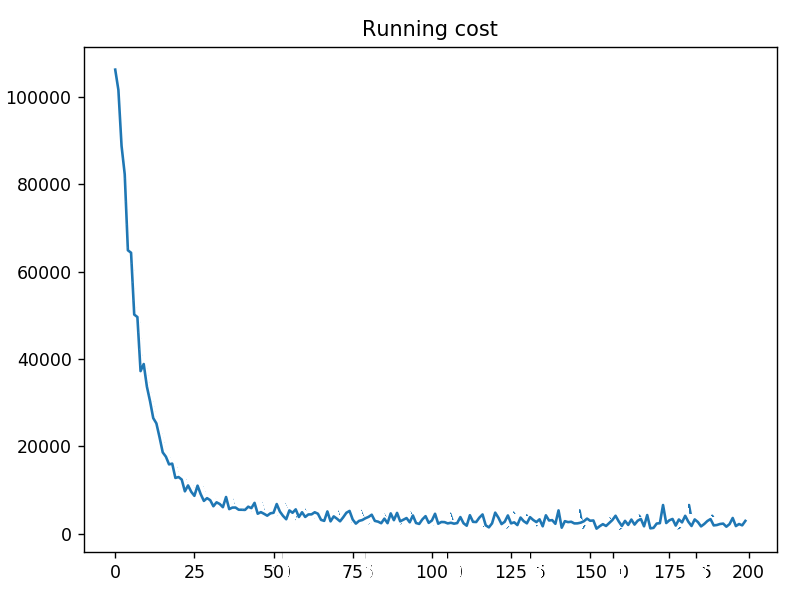

In [22]:
## optimization plotting tool
%matplotlib notebook
import matplotlib.pyplot as plt 

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [ ]:
## optimize

num_iterations = 1000
step_rate = 1e-2

# K has already been initialized above, and initial policy visualized
print K

for cost_iteration in range(num_iterations):
    print K
    cost = 0
    
    for i in range(1000):
        x_i = Variable(torch.randn(2), requires_grad=True)
        Vdot = compute_Vdot(x_i)
        cost += Vdot.clamp(min=0)
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 1 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
    
print K

Variable containing:
 -6.7571
 10.3114
[torch.FloatTensor of size 2]

Variable containing:
 -6.7571
 10.3114
[torch.FloatTensor of size 2]

Variable containing:
-12.3485
 19.0439
[torch.FloatTensor of size 2]

Variable containing:
-18.6444
 28.0639
[torch.FloatTensor of size 2]

Variable containing:
-24.5789
 36.2828
[torch.FloatTensor of size 2]

Variable containing:
-30.8717
 44.4905
[torch.FloatTensor of size 2]

Variable containing:
-36.5015
 51.9170
[torch.FloatTensor of size 2]

Variable containing:
-42.2738
 58.3490
[torch.FloatTensor of size 2]

Variable containing:
-47.0078
 63.7111
[torch.FloatTensor of size 2]

Variable containing:
-52.4061
 69.6660
[torch.FloatTensor of size 2]

Variable containing:
-56.8106
 74.2345
[torch.FloatTensor of size 2]

Variable containing:
-61.7283
 79.3465
[torch.FloatTensor of size 2]

Variable containing:
-66.3008
 83.4929
[torch.FloatTensor of size 2]

Variable containing:
-70.5796
 87.6659
[torch.FloatTensor of size 2]

Variable containing:

Variable containing:
-153.6247
 158.9476
[torch.FloatTensor of size 2]

Variable containing:
-153.6605
 159.1677
[torch.FloatTensor of size 2]

Variable containing:
-153.7343
 159.4632
[torch.FloatTensor of size 2]

Variable containing:
-153.4508
 159.8199
[torch.FloatTensor of size 2]

Variable containing:
-153.7241
 159.9755
[torch.FloatTensor of size 2]

Variable containing:
-154.0802
 160.1363
[torch.FloatTensor of size 2]

Variable containing:
-154.2179
 160.3435
[torch.FloatTensor of size 2]

Variable containing:
-154.2095
 160.6872
[torch.FloatTensor of size 2]

Variable containing:
-154.1865
 161.1051
[torch.FloatTensor of size 2]

Variable containing:
-154.2011
 161.3493
[torch.FloatTensor of size 2]

Variable containing:
-154.0810
 161.7270
[torch.FloatTensor of size 2]

Variable containing:
-154.1069
 161.9573
[torch.FloatTensor of size 2]

Variable containing:
-154.2113
 162.2289
[torch.FloatTensor of size 2]

Variable containing:
-154.4449
 162.4075
[torch.FloatTensor of s